In [1]:
from quilt.data.haradai1262 import YouTuber
!pip install janome

In [2]:
df = YouTuber.channel_videos.UUUM_videos()
df = df[df['cid'] == 'UCZf__ehlCEBPop___sldpBUQ'].reset_index(drop=True)

In [3]:
#タイトルの長さを確認
df['len_title'] = df['title'].apply(lambda x: len(str(x).replace(' ', '')))

In [8]:
df_OneMillion = df[df["viewCount"] >3000000]

In [10]:
#形態素解析
from janome.tokenizer import Tokenizer
import collections

list_tword = []
t = Tokenizer()
for i in range(len(df_OneMillion)):
    title = df_OneMillion.iloc[i,1]
    for token in t.tokenize(title):
        list_tword.append((token.surface))
        c = collections.Counter(list_tword)
print(c)

Counter({'！': 197, '゙': 194, 'て': 158, 'た': 116, ' ': 114, '【': 107, '】': 105, 'の': 99, 'み': 76, 'に': 72, 'し': 59, '゚': 51, 'ヒカキン': 50, 'を': 36, 'で': 36, 'たら': 35, 'か': 28, '超': 25, '…': 24, '円': 22, 'www': 22, 'と': 22, 'が': 21, 'へ': 20, '巨大': 18, '食': 17, '万': 16, 'w': 15, '作っ': 15, '大': 14, 'vs': 13, '!?': 13, '、': 11, '買っ': 11, 'セイ': 11, 'キン': 11, '。': 11, 'ない': 10, 'ヒ': 10, 'なっ': 10, 'こと': 10, 'な': 10, '×': 9, '&': 9, '開封': 9, 'ハ': 9, 'まし': 9, 'やっ': 9, '.': 9, 'は': 8, 'すぎ': 8, 'い': 8, '『': 8, '』': 8, 'せ': 8, '゙てみた': 8, '大量': 7, 'ヤハ': 7, '入れ': 7, 'ー': 7, 'カ': 7, '100': 7, 'ヘ': 7, '食べ': 7, '注意': 7, 'から': 7, 'iPhone': 7, 'テ': 7, '個': 7, '？': 7, 'YouTube': 7, '゙で': 6, '動画': 6, '風呂': 6, 'トル': 6, 'ホ': 6, '1': 6, 'まさかの': 6, '閲覧': 6, '悲報': 6, 'フ': 6, 'もの': 6, 'する': 6, 'ラーメン': 6, 'UFO': 6, '大当たり': 6, '自販機': 6, '!?】': 5, '全部': 5, '分': 5, 'お': 5, 'ひ': 5, 'ます': 5, '家': 5, '2': 5, '食い': 5, '高級': 5, '飲ん': 5, 'YouTuber': 5, 'ヤバ': 5, 'スソース': 5, 'なる': 5, '10': 5, '件': 5, '(': 5, '1000': 5, ')': 5, 

In [11]:
#[]が含まれるなら1,含まれないなら0

buzz_word_Braces = ["【","】",]
for i in buzz_word_Braces:
    df.loc[df['title'].str.contains(i),"title_encode_Braces"] = 1
df.loc[df['title_encode_Braces'].isnull(),"title_encode_Braces"] = 0

In [12]:
#バズりやすい言葉があれば1,それ以外を0

buzz_word = ["vs","www","巨大","大量"]
for n in buzz_word:
    df.loc[df['title'].str.contains(n),"title_encode_word"] = 1
df.loc[df['title_encode_word'].isnull(),"title_encode_word"] = 0

In [13]:
df["len_title"].describe()

count    501.000000
mean      28.856287
std       10.370116
min        8.000000
25%       22.000000
50%       28.000000
75%       34.000000
max       87.000000
Name: len_title, dtype: float64

In [14]:
df.loc[df['len_title'] > 28,"title_encode_len"] = 2
df.loc[df['len_title'] < 28 ,"title_encode_len"] = 1
df.loc[df['len_title'] < 22,"title_encode_len"] = 0

In [15]:
#100万再生なら1,違うなら0とする
df.loc[df['viewCount'] > 3000000,"view_encode"] = 1
df.loc[df['view_encode'].isnull(),"view_encode"] = 0

In [17]:
#データフレームを整える
df2 = df[['title_encode_Braces','title_encode_word','title_encode_len']]
df2 = df2.fillna(0)

In [18]:
#モデルの構築
import numpy as np
import numpy.random as random
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = df2
Y = df['view_encode']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [19]:
#決定木

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# 決定木インスタンス(木の深さ3)
model = DecisionTreeClassifier(max_depth=8)
#学習モデル構築。引数に訓練データの特徴量と、それに対応したラベル
model.fit(X_train, y_train)
predicted = model.predict(X_test)

# .scoreで正解率を算出。
print("train score:",model.score(X_train,y_train))
print("test score:",model.score(X_test,y_test))

train score: 0.6026666666666667
test score: 0.5


In [20]:
#混同行列の作成
plot_cm = confusion_matrix(predicted,y_test)
plot_cm

array([[34, 39],
       [24, 29]])

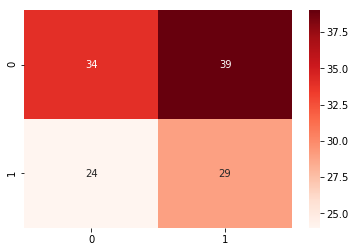

In [22]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(plot_cm, annot=True, cmap='Reds')